# Remove Outliers

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.spatial import distance


# Load your dataset
df = pd.read_csv('combined_datasheets.csv')

# Separate features and target variable
X = df.drop('NLOS', axis=1)
# y = df['NLOS']

# Calculate the Mahalanobis distance for each data point 
covariance_matrix = np.cov(X.T) 
mean_vector = np.mean(X, axis=0) 
mahalanobis_distances = distance.cdist(X, [mean_vector], metric='mahalanobis', VI=np.linalg.inv(covariance_matrix)) 
 
# Convert squared Mahalanobis distances to probabilities using Chi-Squared distribution 
df_mahalanobis_prob = 1 - sp.stats.chi2.cdf(mahalanobis_distances**2, df=X.shape[1]) 

# Define a significance level (e.g., 0.05 for 95% confidence) 
alpha = 0.05
 
# Identify outliers based on the Chi-Squared probabilities 
outliers = df_mahalanobis_prob < alpha 
 
# Remove outliers from the original DataFrame 
df_cleaned = df[~outliers]
# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv('cleaned_data.csv', index=False)


# Import Cleaned Data

In [17]:
 # Load the dataset
df = pd.read_csv('cleaned_data.csv')
# Define the features variable
features = df.columns[1:] # Select all columns except the first one (Target Variable)


# Split into Training and Test data

In [18]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = df.drop('NLOS', axis=1)
y = df['NLOS']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.shape)
print(y_test.shape)

(30058,)
(7515,)


# Standardize Data

In [19]:
from sklearn.preprocessing import StandardScaler
# Preprocess your data (standardize it) 
scaler = StandardScaler() 
df_scaled = scaler.fit_transform(df[features]) # Apply scaling to the selected features
X_train_scaled = scaler.fit_transform(X_train) # Apply scaling to the training set
X_test_scaled = scaler.transform(X_test) # Apply the same scaling to the test set

# Scree Plot

[0.44815874 0.16941664 0.09837396 0.05965299 0.03467712 0.03091025
 0.0277411  0.02612442 0.02064248 0.01822368 0.01278091 0.01142751
 0.00923592 0.00825369 0.00759804 0.00655426 0.00466388 0.00370818
 0.00185622]


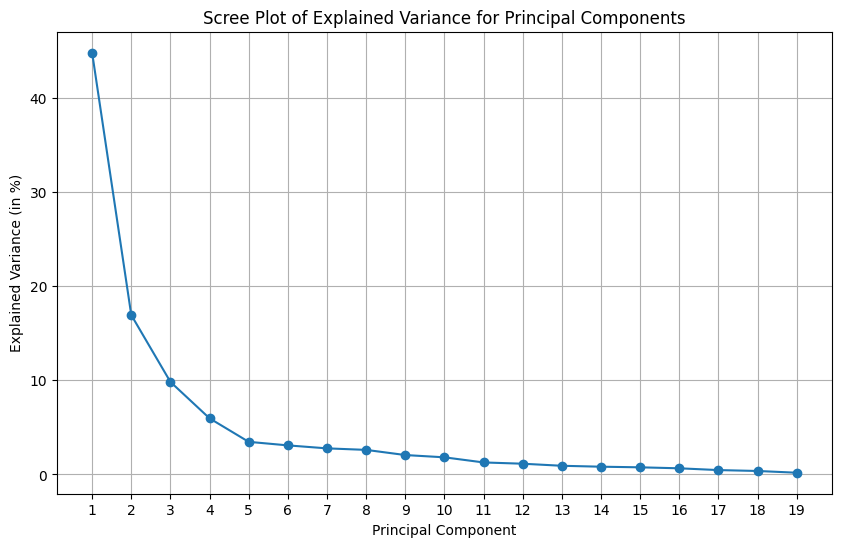

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca1 = PCA() # Adjust the number of components as needed 

pca_components = pca1.fit_transform(df_scaled) # Fit PCA on the entire dataset

explained_variance_ratio = pca1.explained_variance_ratio_
print(explained_variance_ratio)
plt.figure(figsize=(10, 6))

# Create a scree plot to visualize the explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), # x-axis
         explained_variance_ratio*100, # convert explained variance in percentage
         marker='o', # add a marker at each value
        )

# Add title and axis label
plt.title('Scree Plot of Explained Variance for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (in %)')

# Add label to x-axis
plt.xticks(range(1, len(explained_variance_ratio) + 1))

# Add grid in the background
plt.grid(True)

# Display the chart
plt.show()

# Reduce Dimensionality using PCA

In [21]:
pca = PCA(4) # Set number of components to 4 as per the elbow point

pca_components = pca.fit_transform(df_scaled) # Fit PCA on the entire dataset
explained_variance_ratio = pca.explained_variance_ratio_

# To know how many PCA components are there
print("Number of PCA components retained:", pca.n_components_)

# Create a DataFrame for the PCA components 
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)]) 

#Apply transformation to the training set
pca_train_components = pca.fit_transform(X_train_scaled) 

# Create a DataFrame for the PCA components of the training set
pca_train_df = pd.DataFrame(pca_train_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)]) 

# Apply the same PCA transformation to the test set
pca_test_components = pca.transform(X_test_scaled)

# Create a DataFrame for the PCA components of the test set
pca_test_df = pd.DataFrame(pca_test_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])


Number of PCA components retained: 4


# Total Explained Variance 

In [22]:
import plotly.express as px

# Add the class variable back to the DataFrame for coloring 
pca_df['NLOS'] = df['NLOS'] 
 
# Calculate the total explained variance
total_var = explained_variance_ratio.sum() * 100

# Create a PCA plot using Plotly 
fig = px.scatter(pca_df, x='PC1', y='PC2', color='NLOS', title=f'Total Explained Variance: {total_var:.2f}%')

fig.show()

 

# Ranking the importance of features based on its loadings (Eigenvalues)

In [23]:
# Calculate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Rank features based on their absolute loadings for each principal component
for i in range(pca.n_components_):
    ranked_features = np.argsort(np.abs(loadings[:, i]))[::-1]
    
    # Sort features according to their rankings
    sorted_features = [features[idx] for idx in ranked_features]
    
    # Prepare data for plotting
    ranked_features_df = pd.DataFrame(loadings[ranked_features, i], index=sorted_features, columns=[f'PC{i+1}'])
    
    # Plotting the loadings for each principal component
    fig = px.bar(ranked_features_df, x=ranked_features_df.index, y=f'PC{i+1}', title=f'Loadings of Variables in PC{i+1}')
    fig.update_xaxes(tickangle=45, tickfont=dict(size=8))
    fig.show()


# Grid Search with SVM


In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid for SVM
param_grid_svm = {
    'C':[0.01,0.1,1], #Penalty Parameter
    'gamma' : [0.1,1,10], #Coefficient Gamma
    'kernel': ['linear', 'rbf'] # Including 'linear' kernel along with 'rbf' for both linear and non-linear
}

# Create the SVM model
svm = SVC()

# Create a KFold object with a specified random_state
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

# Instantiate the grid search model with the KFold object
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=kfold, n_jobs=-1, verbose=2)

# Fit the grid search to the PCA-transformed data
grid_search_svm.fit(pca_train_df, y_train)

# Print the best parameters and best estimator
print("SVM Best Parameters:", grid_search_svm.best_params_)
print("SVM Best Estimator:", grid_search_svm.best_estimator_)
print("Accuracy:", grid_search_svm.best_score_*100)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   6.6s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   6.9s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   6.9s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   6.8s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   6.9s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.3s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.3s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   5.5s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   5.5s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   5.8s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.7s
[CV] END ......................C=0.01, gamma=0.1

# Grid Search with RF

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300], #Number of Trees
    'max_depth': [None, 10, 20], #Depth of Trees
    'min_samples_split': [2, 5, 10] #Number of Splits
}

# Create the Random Forest model
rf = RandomForestClassifier()

# Create a KFold object with a specified random_state 
kfold = KFold(n_splits=5, random_state=42, shuffle=True) 
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, n_jobs=-1, verbose=2, cv = kfold)

# Fit the grid search to the PCA-transformed data
grid_search_rf.fit(pca_train_df, y_train)

# Print the best parameters and best estimator
print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("Random Forest Best Estimator:", grid_search_rf.best_estimator_)
print("Accuracy:", grid_search_rf.best_score_*100)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  10.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  11.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  11.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  12.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  12.4s
[CV] END max_depth=None, 

# SVM predict with Training Set

SVM Metrics:
Accuracy: 0.866957216048972
Precision: 0.9170700738036663
Recall: 0.7964162646450723
F1 Score: 0.8524952971118734


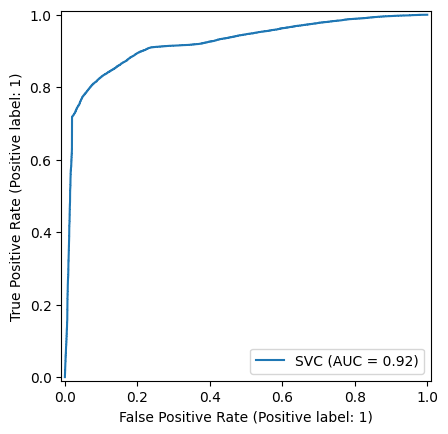

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay
# Define the SVM model with specific hyperparameters
svm = SVC(C=1, gamma=1, kernel='rbf', random_state=42)

# Fit the model to the PCA-transformed training data
svm.fit(pca_train_df, y_train)

# Predict on the training set
y_pred_svm = svm.predict(pca_train_df)

# Calculate metrics
svm_training_accuracy = accuracy_score(y_train, y_pred_svm)
svm_training_precision = precision_score(y_train, y_pred_svm)
svm_training_recall = recall_score(y_train, y_pred_svm)
svm_training_f1 = f1_score(y_train, y_pred_svm)

# Print metrics
print("SVM Metrics:")
# print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Accuracy:", svm_training_accuracy)
print("Precision:", svm_training_precision)
print("Recall:", svm_training_recall)
print("F1 Score:", svm_training_f1)

svc_disp = RocCurveDisplay.from_estimator(svm, pca_train_df, y_train)
# Plot the ROC curve
plt.show()



# SVM predict with Test Set

SVM Metrics:
Accuracy: 0.8573519627411843
Precision: 0.8994692475803934
Recall: 0.7934453318645002
F1 Score: 0.8431372549019608


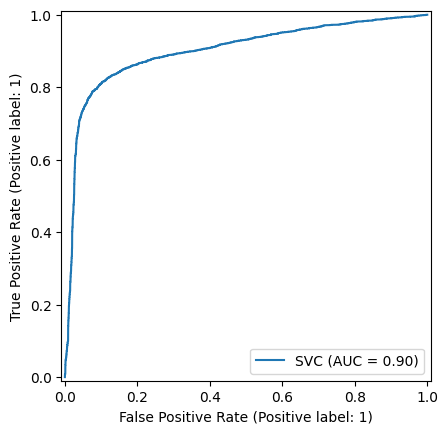

In [27]:
# Define the SVM model with specific hyperparameters
svm = SVC(C=1, gamma=1, kernel='rbf', random_state=42)

# Fit the model to the PCA-transformed training data
svm.fit(pca_train_df, y_train)

# Predict on the training set
y_pred_svm = svm.predict(pca_test_df)

# Calculate metrics
svm_test_accuracy = accuracy_score(y_test, y_pred_svm)
svm_test_precision = precision_score(y_test, y_pred_svm)
svm_test_recall = recall_score(y_test, y_pred_svm)
svm_test_f1 = f1_score(y_test, y_pred_svm)

# Print metrics
print("SVM Metrics:")
# print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Accuracy:", svm_test_accuracy)
print("Precision:", svm_test_precision)
print("Recall:", svm_test_recall)
print("F1 Score:", svm_test_f1)

svc_disp = RocCurveDisplay.from_estimator(svm, pca_test_df, y_test)
# Plot the ROC curve
plt.show()



# RF predict with Training Set

Random Forest Metrics:
Accuracy: 0.8827267283252379
Precision: 0.9335385586865578
Recall: 0.8150930392832529
F1 Score: 0.8703042790389639


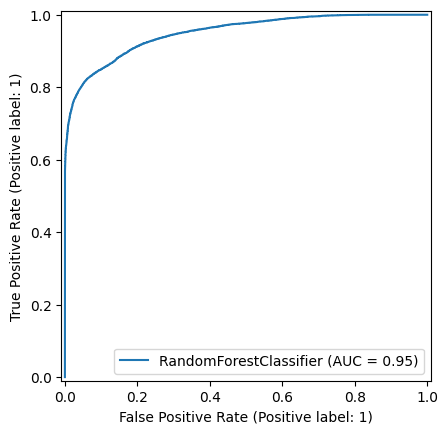

In [28]:
# Define the Random Forest model with specific hyperparameters
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)

# Fit the model to the PCA-transformed training data
rf.fit(pca_train_df, y_train)

# Predict on the training set
y_pred_rf = rf.predict(pca_train_df)

# Calculate metrics
rf_training_accuracy = accuracy_score(y_train, y_pred_rf)
rf_training_precision = precision_score(y_train, y_pred_rf)
rf_training_recall = recall_score(y_train, y_pred_rf)
rf_training_f1 = f1_score(y_train, y_pred_rf)

# Print metrics
print("Random Forest Metrics:")
print("Accuracy:", rf_training_accuracy)
print("Precision:", rf_training_precision)
print("Recall:", rf_training_recall)
print("F1 Score:", rf_training_f1)


# Create a ROC curve display from the estimator
rf_disp = RocCurveDisplay.from_estimator(rf, pca_train_df, y_train)

# Plot the ROC curve
plt.show()


# RF predict with Test Set

Random Forest Metrics:
Accuracy: 0.8565535595475715
Precision: 0.8982839313572543
Recall: 0.7928945194161388
F1 Score: 0.842305441778818


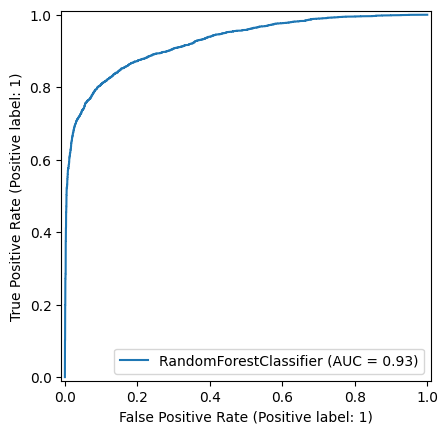

In [29]:
# Define the Random Forest model with specific hyperparameters
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)

# Fit the model to the PCA-transformed training data
rf.fit(pca_train_df, y_train)

# Predict on the test set
y_pred_rf = rf.predict(pca_test_df)

# Calculate metrics
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
rf_test_precision = precision_score(y_test, y_pred_rf)
rf_test_recall = recall_score(y_test, y_pred_rf)
rf_test_f1 = f1_score(y_test, y_pred_rf)

# Print metrics
print("Random Forest Metrics:")
print("Accuracy:", rf_test_accuracy)
print("Precision:", rf_test_precision)
print("Recall:", rf_test_recall)
print("F1 Score:", rf_test_f1)

# Create a ROC curve display from the estimator
rf_disp = RocCurveDisplay.from_estimator(rf, pca_test_df, y_test)

# Plot the ROC curve
plt.show()


# Comparision of Random Forest and SVM Accuracies of Test & Training Set

In [30]:
import plotly.graph_objects as go

# Assuming svm_test_accuracy, rf_test_accuracy, svm_training_accuracy, and rf_training_accuracy are defined

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Test', x=['SVM', 'Random Forest'], y=[svm_test_accuracy, rf_test_accuracy],
           text=[f'{svm_test_accuracy:.3f} ({svm_test_accuracy:.3f}%)', f'{rf_test_accuracy:.3f} ({rf_test_accuracy:.3f}%)'],
           textposition='auto'),
    go.Bar(name='Training', x=['SVM', 'Random Forest'], y=[svm_training_accuracy, rf_training_accuracy],
           text=[f'{svm_training_accuracy:.3f} ({svm_training_accuracy:.3f}%)', f'{rf_training_accuracy:.3f} ({rf_training_accuracy:.3f}%)'],
           textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='group', title_text='Accuracy Comparison')

# Show the plot
fig.show()


# Heat Map for Metrics

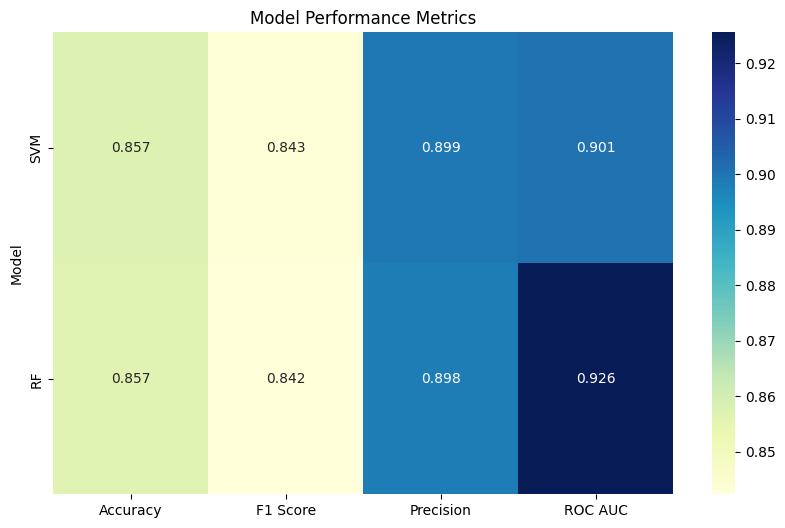

In [31]:
import seaborn as sns
# Organize data in a DataFrame
data = {
    'Model': ['SVM', 'RF'],
    'Accuracy': [svm_test_accuracy, rf_test_accuracy],
    'F1 Score': [svm_test_f1, rf_test_f1],
    'Precision': [svm_test_precision, rf_test_precision],
    'ROC AUC': [svc_disp.roc_auc, rf_disp.roc_auc] # Assuming svc_disp and rf_disp are RocCurveDisplay objects
}
df = pd.DataFrame(data)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.set_index('Model'), annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Model Performance Metrics')
plt.show()


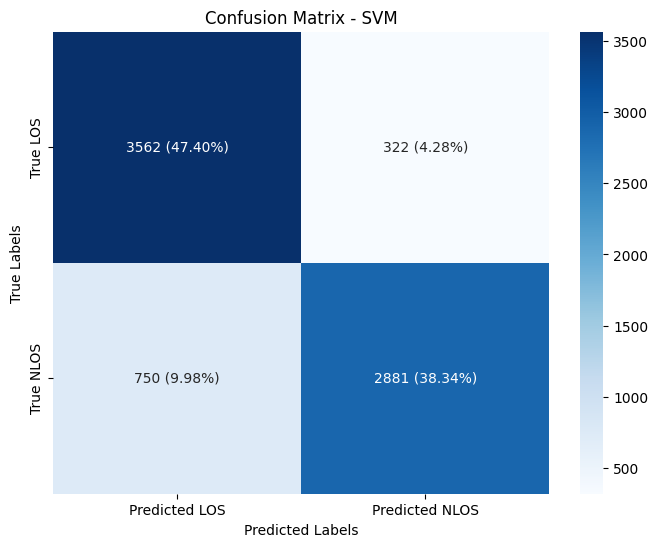

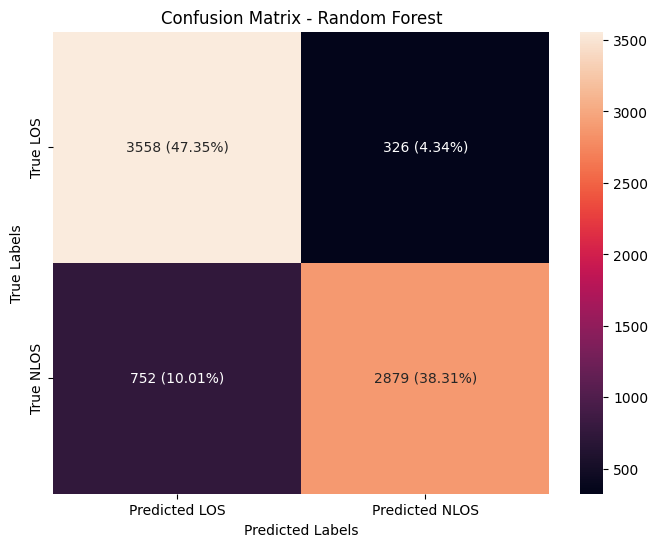

[[3558  326]
 [ 752 2879]]
[[3562  322]
 [ 750 2881]]


In [32]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Function to format annotations with both numbers and percentages
def format_func(value, tick_number):
    return f"{value} ({value / sum(sum(cm_svm)) * 100:.2f}%)"

# Calculate the confusion matrix for SVM predictions
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix with both numbers and percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_svm, annot=True, fmt='g', cmap='Blues')
ax.set_xticklabels(['Predicted LOS', 'Predicted NLOS'])
ax.set_yticklabels(['True LOS', 'True NLOS'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Format annotations with both numbers and percentages
for t in ax.texts:
    t.set_text(format_func(int(t.get_text()), t.get_position()[1]))

plt.show()

# Calculate the confusion matrix for RF predictions
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix with both numbers and percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_rf, annot=True, fmt='g')
ax.set_xticklabels(['Predicted LOS', 'Predicted NLOS'])
ax.set_yticklabels(['True LOS', 'True NLOS'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Format annotations with both numbers and percentages
for t in ax.texts:
    t.set_text(format_func(int(t.get_text()), t.get_position()[1]))

plt.show()

print(cm_rf)
print(cm_svm)


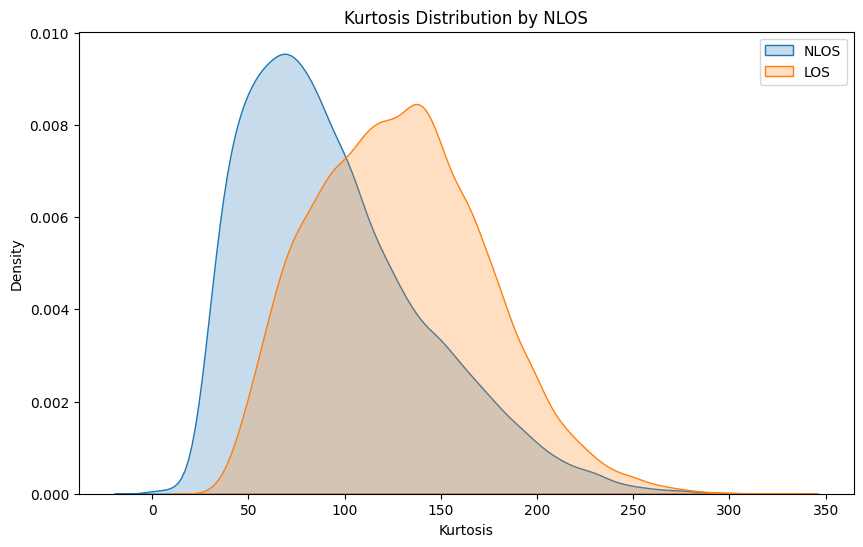

In [34]:
# Load your dataset
df = pd.read_csv('/Users/veleonlim/Downloads/Data Analytics/UWB-LOS-NLOS-Data-Set/combined_datasheets_changed.csv')



# Plotting
plt.figure(figsize=(10, 6))

# KDE plot for NLOS
sns.kdeplot(data=df[df['NLOS'] == 1]['KURTOSIS'], label='NLOS', fill=True)

# KDE plot for LOS
sns.kdeplot(data=df[df['NLOS'] == 0]['KURTOSIS'], label='LOS', fill=True)

plt.title('Kurtosis Distribution by NLOS')
plt.xlabel('Kurtosis')
plt.ylabel('Density')
plt.legend()
plt.show()
